In [1]:
from matplotlib import pyplot as plt
from statistics import mean
from statistics import stdev
from statistics import median
from scipy.stats import skew
from scipy.stats import kurtosis
from scipy import stats
import pandas as pd
import statsmodels.formula.api as sm
import statsmodels.stats.sandwich_covariance as sw
import numpy as np
import statsmodels as statsmodels
import statsmodels.api as smf
from statsmodels.graphics import tsaplots
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%run positions.ipynb

2015-01-30T00:00:00.000000000
2015-02-27T00:00:00.000000000
2015-03-31T00:00:00.000000000
2015-04-30T00:00:00.000000000
2015-05-28T00:00:00.000000000
2015-06-30T00:00:00.000000000
2015-07-30T00:00:00.000000000
2015-08-28T00:00:00.000000000
2015-09-30T00:00:00.000000000
2015-10-29T00:00:00.000000000
2015-11-25T00:00:00.000000000
2015-12-30T00:00:00.000000000
2016-01-29T00:00:00.000000000
2016-02-29T00:00:00.000000000
2016-03-31T00:00:00.000000000
2016-04-29T00:00:00.000000000
2016-05-26T00:00:00.000000000
2016-06-30T00:00:00.000000000
2016-07-29T00:00:00.000000000
2016-08-31T00:00:00.000000000
2016-09-28T00:00:00.000000000
2016-10-31T00:00:00.000000000
2016-11-30T00:00:00.000000000
2016-12-30T00:00:00.000000000
2017-01-31T00:00:00.000000000
2017-02-28T00:00:00.000000000
2017-03-31T00:00:00.000000000
2017-04-28T00:00:00.000000000
2017-05-31T00:00:00.000000000
2017-06-30T00:00:00.000000000
2017-07-31T00:00:00.000000000
2017-08-31T00:00:00.000000000
2017-09-28T00:00:00.000000000
2017-10-31

C:\Users\Miro_\AppData\Local\Temp/ipykernel_17524/1498460402.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1_libor_3M_original['date2'] =  data1_libor_3M_original['date'].dt.to_period('M')


<AxesSubplot:>

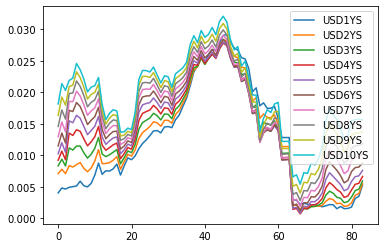

In [3]:
model_swap_rates.loc[:,'USD1YS':].plot()

In [4]:
book_dict[dates[0]].columns

Index(['date', 'Trade type', 'M from open', 'Maturity', 'M to float',
       'M to fixed', 'S of model', 'S of trade', 'S of H1', 'S of H10',
       'Latest 3ML', 'Previous total dirty', 'Previous trade dirty',
       'Previous H1 dirty', 'Previous H10 dirty', 'Nominal trade',
       'Nominal H1', 'Nominal H10', 'Weight H1', 'Weight H10',
       'Initial mispricing', 'Current mispricing', 'Current total dirty',
       'Current trade dirty', 'Current H1 dirty', 'Current H10 dirty'],
      dtype='object')

In [5]:
# Constants for modifying plots and returns from % to bps and vice versa
bps = 0.0001
bpsmult = 10000

Text(0, 0.5, 'Bps')

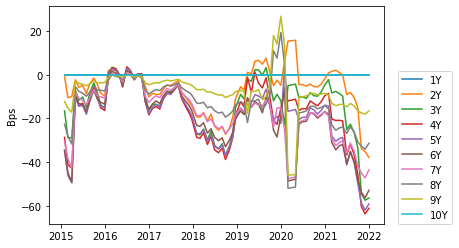

In [6]:
# Plotting the mispricings in basis points
mispricings = model_swap_rates.loc[:,'USD1YS':'USD10YS'].reset_index().drop(['index'],axis=1) - data1_swap_trade.loc[40:,'USD1YS':'USD10YS'].reset_index().drop(['index'],axis=1)
mispricings = mispricings*bpsmult #Modifying the mispricings to basis points
plt.plot(model_swap_rates['date'], mispricings)
plt.legend(['1Y','2Y','3Y','4Y','5Y','6Y','7Y','8Y','9Y','10Y'], loc=(1.04,0))
plt.ylabel('Bps')
#plt.savefig('subp_CIR_misprices.eps', bbox_inches='tight')

## Calculating the returns for open trades at each month ##

In [7]:
# All trades
monthly_ret_data = [] # List of tuples: (date, list of returns by position in a month)
for date in dates:
    date_book = book_dict[date]
    date_returns = [] # list of returns by position in a month
    for index, row in date_book.iterrows():
        curr = row[22]
        prev = row[11]
        m_from_open = row[2]
        if m_from_open != 0:
            #ret = (curr-prev)/(row[15] + row[16] + row[17]) #unlevered
            ret = (curr-prev)/(100 + 100*row[18] + 100*row[19]) #levered
            date_returns.append(ret)
    monthly_ret_data.append((date,date_returns))

## Calculating the total portfolio value at each month ##

Text(0, 0.5, '$ - value')

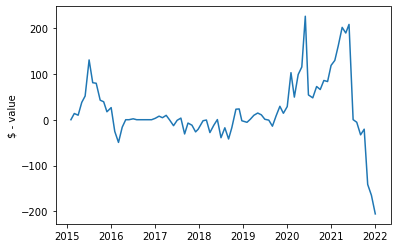

In [8]:
# All trades, total portfolio value
value_data = [] 
for date in dates:
    date_df = book_dict[date]
    curr_data = []
    for index, row in date_df.iterrows():
        curr = row[22]
        curr_data.append(curr)
    sumcurr = sum(curr_data)
    value_data.append(sumcurr)

# Plotting the total portfolio value
plt.plot(model_swap_rates['date'], value_data)
plt.ylabel('$ - value')
#plt.savefig('portfoliovalue_CIR_subp_5bps.eps')

## Calculating the monthly ex-trading cost returns ##

In [9]:
monthly_mean_ret = []
for ret_tuple in monthly_ret_data:
    date = ret_tuple[0]
    returns = ret_tuple[1]
    trade_cost = closed_trades_df[closed_trades_df['date']==date].values[0][1]*bps
    if len(returns) != 0:
        mean_ret = mean(returns)
        mean_ret_trade_cost = mean_ret - trade_cost
        monthly_mean_ret.append(mean_ret_trade_cost)
    else:
        monthly_mean_ret.append(-trade_cost)

Text(0, 0.5, '%')

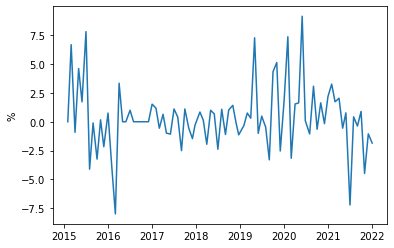

In [10]:
# Modifying ex-trading cost return data to % for plotting
monthly_mean_ret_perc = [ele * 100 for ele in monthly_mean_ret]

# Plotting the monthly ex-trading cost returns
plt.plot(model_swap_rates['date'], monthly_mean_ret_perc)
plt.ylabel('%')
#plt.savefig('extradecostreturns.eps')

## Calculating the return statistics in basis points ##

In [11]:
# Number of observations
len(monthly_mean_ret[1:])

83

In [12]:
# Mean of returns
mean(monthly_mean_ret[1:]) * bpsmult

1.4727229696828068

In [13]:
# Stdev of returns
stdev(monthly_mean_ret[1:])

0.001767991902375748

In [11]:
# Annual stdev
stdev(monthly_mean_ret[1:]) * np.sqrt(12)

0.09884900994165344

In [15]:
# Solving the required leverage ratios
0.1/0.006124503604570299

16.327853889313875

In [16]:
# Median of returns
median(monthly_mean_ret[1:]) * bpsmult

-0.0

In [17]:
# Min of returns
min(monthly_mean_ret[1:]) * bpsmult

-583.0629628384504

In [18]:
# Max of returns
max(monthly_mean_ret[1:]) * bpsmult

1072.8849511665276

In [19]:
# Non-corrected skewness of returns
skew(monthly_mean_ret[1:])

0.5805414394625852

In [20]:
# Non-corrected kurtosis of returns
kurtosis(monthly_mean_ret[1:])

2.0064263549730272

In [21]:
# Annualized sharpe ratio of returns
(mean(monthly_mean_ret[1:])/stdev(monthly_mean_ret[1:])) * np.sqrt(12)

0.13097006210998496

In [22]:
# Ratio of negative returns
sum(1 for i in monthly_mean_ret[1:] if i < 0)/len(monthly_mean_ret[1:])

0.4457831325301205

Text(0, 0.5, '%')

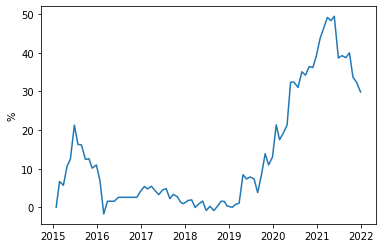

In [12]:
# Plot of cumulative returns (in %)
mean_list_1 = []
newval = 1
for meanval in monthly_mean_ret:
    newval = newval * (1 + meanval)
    mean_list_1.append((newval-1)*100)
from matplotlib import pyplot as plt
plt.plot(model_swap_rates['date'].loc[0:], mean_list_1)
plt.ylabel('%')
#plt.title('Cumulative returns 09/2011 - 12/2021')
#plt.savefig('subp_circumu_5bps.eps')

## HAC robust standard errors with 1 lag and corresponding t-stat, skewness and kurtosis<br> Plotting and calculating autocorrelation (serial correlation) coefficients ##

In [25]:
# Non-corrected t-statistic for comparison
stats.ttest_1samp(monthly_mean_ret, 0)

Ttest_1sampResult(statistic=0.344467489231765, pvalue=0.7313660123916139)

In [26]:
# Test statistics with HAC robust standard errors
mkt_data = pd.DataFrame(monthly_mean_ret, columns=['rets'])
one = np.ones(len(monthly_mean_ret))
mkt_data['one'] = 1
model = sm.ols( formula = 'rets ~ one',data = mkt_data).fit(cov_type='HAC', cov_kwds={'maxlags': 1}, use_t=True)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   rets   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                    0.1126
Date:                Wed, 11 May 2022   Prob (F-statistic):              0.738
Time:                        00:15:23   Log-Likelihood:                 182.92
No. Observations:                  84   AIC:                            -363.8
Df Residuals:                      83   BIC:                            -361.4
Df Model:                           0                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0005      0.002      0.336      0.738      -0.003       0.004
one            0.0005      0.002      0.336      0.738      -0.003       0.004
==============================================================================
Omnibus:                       12.513   Durbin-Watson:                   1.859
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               19.760
Skew:                           0.585   Prob(JB):                     5.12e-05
Kurtosis:                       5.068   Cond. No.                     5.07e+15
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 1 lags and without small sample correction
[2] The smallest eigenvalue is 6.54e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

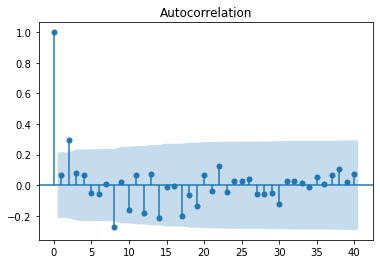

In [27]:
#Plotting autocorrelation function
fig = tsaplots.plot_acf(monthly_mean_ret, lags=40)
plt.show()

In [29]:
from statsmodels.tsa import stattools
# x = 1-D array
# Yield normalized autocorrelation function of number lags
autocorr = stattools.acf(monthly_mean_ret)

# Get autocorrelation coefficient at lag = 1
autocorr_coeff = autocorr[1]
autocorr_coeff

0.06669120961339323

## Testing autocorrelation with Durbin-Watson and Breusch-Godfrey. Not separately testing heteroskedasticity with Breusch-Pagan or other tests ##

In [30]:
import statsmodels.stats.stattools as sm_tools
print(sm_tools.durbin_watson(model.resid))

1.8591767847463447


In [31]:
from statsmodels.stats.stattools import durbin_watson
durbin_watson(model.resid)

1.8591767847463447

In [32]:
import statsmodels.stats.diagnostic as dg

#perform Breusch-Godfrey test at order p = 3
print(dg.acorr_breusch_godfrey(model, nlags=40))

(43.2790066679545, 0.33317269078107487, 1.1425294021852384, 0.3335006210492282)


## Histograms of returns ##

Text(0, 0.5, 'Count')

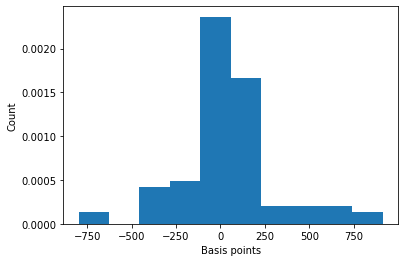

In [13]:
# Plotting histogram of returns
mean_list_hist = [ele*bpsmult for ele in monthly_mean_ret] 
plt.hist(mean_list_hist, density=True)
plt.xlabel('Basis points')
plt.ylabel('Count')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

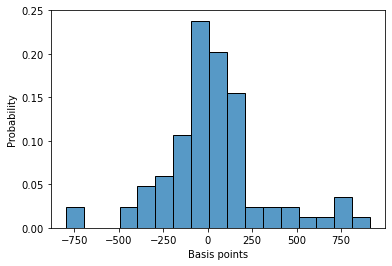

In [16]:
p = sns.histplot(data=mean_list_hist, stat='probability')
p.set_xlabel('Basis points')
p.figure.savefig('subp_vasi_hist_5bps.eps')

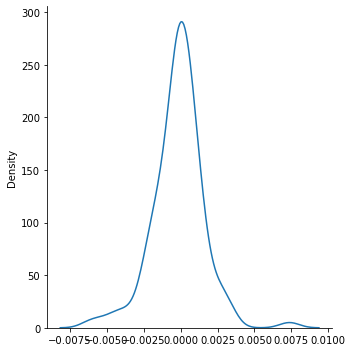

In [34]:
# Plotting continuous return distribution
sns.displot(data=monthly_mean_ret, kind="kde")

## OTHER ##

In [ ]:
'''
from dateutil.parser import parse
xls_tied = pd.ExcelFile('smith_test.xlsx')

swap = xls_tied.parse('swap')
ois = xls_tied.parse('ois')
libor = xls_tied.parse('libor')
data_test = xls_tied.parse('testaus')

paiva = parse('2021-03-01')
a_val = vn.valuate_float(paiva, 0.005, libor, ois, swap, 3, 3, 24, 100000000, 3, 3, "Act/360", "Act/360")
b_val = vn.valuate_fixed(paiva, 0.0526, ois, 3, 24, 100000000, 3, "Act/360")
'''

In [ ]:
'''
model = sm.ols( formula = 'rets ~ one',data = mkt_data).fit()
new = model.get_robustcov_results(cov_type='HAC',maxlags=1)
T_test = mean_list.t_test(new.params) 
print(T_test)
'''

In [ ]:
'''
mispricings = model_swap_rates.loc[:,'USD1YS':] - data1_swap_trade.loc[4:,'USD1YS':].reset_index().drop(['index'],axis=1)
mispricings[20:].plot()
'''

In [ ]:
'''
smf.tsa.acf(mean_list)
'''

In [102]:
book_dict

{'First book': Empty DataFrame
 Columns: [date, Trade type, M from open, Maturity, M to float, M to fixed, S of model, S of trade, S of H1, S of H10, Latest 3ML, Previous total dirty, Previous trade dirty, Previous H1 dirty, Previous H10 dirty, Nominal trade, Nominal H1, Nominal H10, Weight H1, Weight H10, Initial mispricing, Current mispricing, Current total dirty, Current trade dirty, Current H1 dirty, Current H10 dirty]
 Index: []
 
 [0 rows x 26 columns],
 Period('2012-01', 'M'):       date Trade type M from open Maturity M to float M to fixed  S of model  \
 0  2012-01      Payer           0        4          3          6     0.01557   
 
    S of trade  S of H1  S of H10  ...  Nominal H1 Nominal H10 Weight H1  \
 0      0.0078  0.00496   0.01941  ...  692.324862  975.106404  0.415531   
 
   Weight H10 Initial mispricing  Current mispricing  Current total dirty  \
 0   0.585256            0.00777             0.00777                  0.0   
 
    Current trade dirty  Current H1 di